### Exploratory Data Analysis with Python

We will explore the NYC MTA turnstile dataset. These data files are from the New York Subway. It tracks the hourly entries and exits to turnstiles by day in the subway system.

The data files are available on MTA's [website](http://web.mta.info/developers/turnstile.html).

In [ ]:
!pip install wget

In [28]:
import os, wget

url_template = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_%s.txt"
for date in ['160206', '160213', '160220', '160227', '160305']:
    url = url_template % date
    if os.path.isfile('data/turnstile_{}.txt'.format(date)):
        print(date, 'file already downloaded')
    else:
        wget.download(url, out='data/')
        print(date, 'file downloaded')

160206 file already downloaded
160213 file already downloaded
160220 file already downloaded
160227 file already downloaded
160305 file already downloaded


Our first step will be to create a dictionary of which the key will be the columns representing a turnstile (C/A, UNIT, SCP, STATION) and the value will be a list of the entries for that turnstile. It should look like so:


    {
        ('A002','R051','02-00-00','LEXINGTON AVE'):    
        [
            ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'],          
            ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'],  
            ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'],
          ...   
        ] 
    }


In [3]:
import csv, glob
from collections import defaultdict

def read_csv(csv_file_name):
    turnstile_to_count_reading = defaultdict(list)
    with open(csv_file_name, 'r') as csv_file:
        mta_reader = csv.reader(csv_file)
        for i, row in enumerate(mta_reader):
            if i == 0:
                continue
                
            turnstile_info = tuple(row[:4])
            count_reading = row[4:]
            turnstile_to_count_reading[turnstile_info].append(count_reading)
            
    return turnstile_to_count_reading

In [4]:
weekly_data_dicts = [read_csv(csvfile) for csvfile in glob.glob('data/turnstile_*.txt')]

In [30]:
sample_dict = list(weekly_data_dicts[0].items())[:1]
sample_dict

[(('R617', 'R058', '00-00-02', 'BERGEN ST'),
  [['23',
    'IRT',
    '01/30/2016',
    '03:00:00',
    'REGULAR',
    '0000532122',
    '0000230836                                             '],
   ['23',
    'IRT',
    '01/30/2016',
    '07:00:00',
    'REGULAR',
    '0000532136',
    '0000230844                                             '],
   ['23',
    'IRT',
    '01/30/2016',
    '11:00:00',
    'REGULAR',
    '0000532297',
    '0000230946                                             '],
   ['23',
    'IRT',
    '01/30/2016',
    '15:00:00',
    'REGULAR',
    '0000532536',
    '0000231080                                             '],
   ['23',
    'IRT',
    '01/30/2016',
    '19:00:00',
    'REGULAR',
    '0000532763',
    '0000231209                                             '],
   ['23',
    'IRT',
    '01/30/2016',
    '23:00:00',
    'REGULAR',
    '0000532859',
    '0000231268                                             '],
   ['23',
    'IRT',
    '01/31/2016',
    

Now let's turn this into a time series. This time our data will be comprised of just the point in time and the cumulative count of entries.

It should look like something like:

    {    
        ('A002','R051','02-00-00','LEXINGTON AVE'):    
            [
                [datetime.datetime(2013, 3, 2, 3, 0), 3788],
                [datetime.datetime(2013, 3, 2, 7, 0), 2585],
                [datetime.datetime(2013, 3, 2, 12, 0), 10653],
                [datetime.datetime(2013, 3, 2, 17, 0), 11016],
                [datetime.datetime(2013, 3, 2, 23, 0), 10666],
                [datetime.datetime(2013, 3, 3, 3, 0), 10814],
                [datetime.datetime(2013, 3, 3, 7, 0), 10229],
              ...
            ],
      ...
    }

In [6]:
from datetime import datetime
from dateutil.parser import parse

def convert_week_data_to_time_series(week_data_dict):
    turnstile_to_time_series = defaultdict(list)
    for i, (turnstile, row_data) in enumerate(week_data_dict.items()):
        if i % 200 == 0:
            print('Processing turnstile', turnstile)
        for lines, division, datestr, timestr, event, cum_entries, cum_exits in row_data:
            timestamp = parse('%sT%s' % (datestr, timestr))
            turnstile_to_time_series[turnstile].append([timestamp, int(cum_entries)])
            
    return turnstile_to_time_series

In [ ]:
weekly_time_series = list(map(convert_week_data_to_time_series, weekly_data_dicts))

In [8]:
sample_turnstile_to_time_series = list(weekly_time_series[0].items())[:2]
sample_turnstile_to_time_series

[(('R617', 'R058', '00-00-02', 'BERGEN ST'),
  [[datetime.datetime(2016, 1, 30, 3, 0), 532122],
   [datetime.datetime(2016, 1, 30, 7, 0), 532136],
   [datetime.datetime(2016, 1, 30, 11, 0), 532297],
   [datetime.datetime(2016, 1, 30, 15, 0), 532536],
   [datetime.datetime(2016, 1, 30, 19, 0), 532763],
   [datetime.datetime(2016, 1, 30, 23, 0), 532859],
   [datetime.datetime(2016, 1, 31, 3, 0), 532902],
   [datetime.datetime(2016, 1, 31, 7, 0), 532914],
   [datetime.datetime(2016, 1, 31, 11, 0), 533030],
   [datetime.datetime(2016, 1, 31, 15, 0), 533261],
   [datetime.datetime(2016, 1, 31, 19, 0), 533425],
   [datetime.datetime(2016, 1, 31, 23, 0), 533489],
   [datetime.datetime(2016, 2, 1, 3, 0), 533500],
   [datetime.datetime(2016, 2, 1, 7, 0), 533541],
   [datetime.datetime(2016, 2, 1, 11, 0), 534116],
   [datetime.datetime(2016, 2, 1, 15, 0), 534259],
   [datetime.datetime(2016, 2, 1, 19, 0), 534431],
   [datetime.datetime(2016, 2, 1, 23, 0), 534494],
   [datetime.datetime(2016, 2, 

These counts are grouped by dataset file (e.g., by week). Let's make it a high-res timeseries by combining multiple weeks.

In [9]:
def combine_multiple_weeks_into_single_high_res_timeseries(weekly_time_series):
    combined_time_series = defaultdict(list)
    for turnstile_to_weeklong_time_series in weekly_time_series:
        for turnstile, weeklong_time_series in turnstile_to_weeklong_time_series.items():
            combined_time_series[turnstile] += weeklong_time_series
            
    # It's already sorted due to the nature of the files
    return combined_time_series


turnstile_to_full_time_series = combine_multiple_weeks_into_single_high_res_timeseries(
    weekly_time_series)

In [29]:
sample_turnstile_to_full_time_series = list(turnstile_to_full_time_series.items())[:2]
sample_turnstile_to_full_time_series

[(('R617', 'R058', '00-00-02', 'BERGEN ST'),
  [[datetime.datetime(2016, 1, 31, 3, 0), 532902],
   [datetime.datetime(2016, 1, 31, 7, 0), 532914],
   [datetime.datetime(2016, 1, 31, 11, 0), 533030],
   [datetime.datetime(2016, 1, 31, 15, 0), 533261],
   [datetime.datetime(2016, 1, 31, 19, 0), 533425],
   [datetime.datetime(2016, 1, 31, 23, 0), 533489],
   [datetime.datetime(2016, 2, 1, 3, 0), 533500],
   [datetime.datetime(2016, 2, 1, 7, 0), 533541],
   [datetime.datetime(2016, 2, 1, 11, 0), 534116],
   [datetime.datetime(2016, 2, 1, 15, 0), 534259],
   [datetime.datetime(2016, 2, 1, 19, 0), 534431],
   [datetime.datetime(2016, 2, 1, 23, 0), 534494],
   [datetime.datetime(2016, 2, 2, 3, 0), 534508],
   [datetime.datetime(2016, 2, 2, 7, 0), 534562],
   [datetime.datetime(2016, 2, 2, 11, 0), 535174],
   [datetime.datetime(2016, 2, 2, 15, 0), 535312],
   [datetime.datetime(2016, 2, 2, 19, 0), 535496],
   [datetime.datetime(2016, 2, 2, 23, 0), 535562],
   [datetime.datetime(2016, 2, 3, 3, 

This seems to be a good time to take a break and ignore January, March, weekends and 2016 NYC holidays (Feb 12th and 15th). The sooner we do it the faster our code will execute.

In [11]:
feb_nyc_holidays = [12, 15]

removed = 0
for turnstile, turnstile_data in turnstile_to_full_time_series.items():
    # iterate over a copy of the list in order to be able to remove items from the original
    for timestamp, cum_entries in list(turnstile_data):
        if timestamp.month != 2 or timestamp.weekday() >= 5 or timestamp.day in feb_nyc_holidays:
            if not (timestamp.month == 1 and timestamp.day == 31):
                # leave the last of january in order to be able to make the cumulative count
                turnstile_data.remove([timestamp, cum_entries])
                removed = removed + 1

print(removed)

828068


Let's also further analyze the timestamps to see if we can easily filter entries between 7am and 5pm. Again, the sooner we do it the faster our code will execute.

In [35]:
turnstiles_timestamps = dict()
for turnstile, turnstile_data in turnstile_to_full_time_series.items():
    timestamps_set = set()
    for timestamp, cum_entries in list(turnstile_data):
        timestamps_set.add(timestamp.time())
    
    turnstiles_timestamps[turnstile] = timestamps_set

In [47]:
turnstiles_timestamps_items_list = list(turnstiles_timestamps.items())
n_turnstiles = len(turnstiles_timestamps_items_list)
n_samples = 4

sample_turnstiles_timestamps = [turnstiles_timestamps_items_list[i] 
                                for i in range(0, n_turnstiles - 1, n_turnstiles // n_samples)]
sample_turnstiles_timestamps

[(('R617', 'R058', '00-00-02', 'BERGEN ST'),
  {datetime.time(3, 0),
   datetime.time(7, 0),
   datetime.time(7, 25, 56),
   datetime.time(9, 3, 3),
   datetime.time(9, 13, 23),
   datetime.time(9, 14, 43),
   datetime.time(9, 16, 3),
   datetime.time(11, 0),
   datetime.time(15, 0),
   datetime.time(19, 0),
   datetime.time(23, 0)}),
 (('PTH19', 'R549', '02-02-03', 'NEWARK C'),
  {datetime.time(0, 4, 32),
   datetime.time(0, 18, 32),
   datetime.time(0, 40, 32),
   datetime.time(0, 46, 32),
   datetime.time(0, 54, 32),
   datetime.time(1, 8, 32),
   datetime.time(1, 16, 32),
   datetime.time(1, 30, 32),
   datetime.time(2, 28, 32),
   datetime.time(2, 42, 32),
   datetime.time(3, 4, 32),
   datetime.time(3, 40, 32),
   datetime.time(3, 54, 32),
   datetime.time(4, 8, 32),
   datetime.time(4, 16, 32),
   datetime.time(4, 30, 32),
   datetime.time(4, 52, 32),
   datetime.time(4, 58, 32),
   datetime.time(5, 6, 32),
   datetime.time(5, 20, 32),
   datetime.time(5, 28, 32),
   datetime.ti

Unfortunately, with only a few turnstile samples we can see that the timestamps in which data was recorded is not regular, with some timesamples being seemingly random. Since each station has multiple turnstiles it makes it hard even to compile timestamp data on a station basis.

Let's ignore the timestamps going forward and work with daily entries. We will have a single value for a single day, which is not cumulative counts but the total number of passengers that entered through this turnstile on this day.

In [12]:
sample_turnstile_to_full_time_series = list(turnstile_to_full_time_series.items())[:2]
sample_turnstile_to_full_time_series

[(('R617', 'R058', '00-00-02', 'BERGEN ST'),
  [[datetime.datetime(2016, 1, 31, 3, 0), 532902],
   [datetime.datetime(2016, 1, 31, 7, 0), 532914],
   [datetime.datetime(2016, 1, 31, 11, 0), 533030],
   [datetime.datetime(2016, 1, 31, 15, 0), 533261],
   [datetime.datetime(2016, 1, 31, 19, 0), 533425],
   [datetime.datetime(2016, 1, 31, 23, 0), 533489],
   [datetime.datetime(2016, 2, 1, 3, 0), 533500],
   [datetime.datetime(2016, 2, 1, 7, 0), 533541],
   [datetime.datetime(2016, 2, 1, 11, 0), 534116],
   [datetime.datetime(2016, 2, 1, 15, 0), 534259],
   [datetime.datetime(2016, 2, 1, 19, 0), 534431],
   [datetime.datetime(2016, 2, 1, 23, 0), 534494],
   [datetime.datetime(2016, 2, 2, 3, 0), 534508],
   [datetime.datetime(2016, 2, 2, 7, 0), 534562],
   [datetime.datetime(2016, 2, 2, 11, 0), 535174],
   [datetime.datetime(2016, 2, 2, 15, 0), 535312],
   [datetime.datetime(2016, 2, 2, 19, 0), 535496],
   [datetime.datetime(2016, 2, 2, 23, 0), 535562],
   [datetime.datetime(2016, 2, 3, 3, 

In [ ]:
from itertools import groupby

def count_within_normal_bounds(count):
    if count is None:
        return True
    else:
        return 10000 > count >= 0

def convert_time_series_to_daily(high_res_time_series):
    daily_time_series = []
    
    def day_of_timestamp(time_series_entry):
        timestamp, tot_entries = time_series_entry
        return timestamp.date()
    
    # groupby() requires data to be sorted. It is sorted already here.
    count_on_previous_day = None
    for day, entries_on_this_day in groupby(high_res_time_series, key=day_of_timestamp):
        # get the maximum cumulative count among the entries on this day
        cum_entry_count_on_day = max([count for time, count in entries_on_this_day])
        # skip the first entry if we don't know the previous day
        if count_on_previous_day is None:
            daily_entries = None
        else:
            daily_entries = cum_entry_count_on_day - count_on_previous_day
        # Save today's count for tomorrow's calculation
        count_on_previous_day = cum_entry_count_on_day
        # Only append if the cumulative increased.
        # Otherwise there is something wrong in the data - skip with a warning.
        if count_within_normal_bounds(daily_entries):
            daily_time_series.append((day, daily_entries))
        else:
            print('WARNING. Abnormal entry count found on day %s: %s' % (day, daily_entries))
            daily_time_series.append((day, None))

    return daily_time_series


def convert_turnstile_to_high_res_time_series_to_daily(turnstile_to_time_series):
    turnstile_to_daily_time_series = {}
    for i, (turnstile, time_series) in enumerate(turnstile_to_time_series.items()):
        print('Processing turnstile', turnstile)
        turnstile_to_daily_time_series[turnstile] = convert_time_series_to_daily(time_series)
    return turnstile_to_daily_time_series


turnstile_to_daily_time_series = convert_turnstile_to_high_res_time_series_to_daily(
    turnstile_to_full_time_series)

In [14]:
turnstile_to_daily_time_series[('N300', 'R113', '01-00-04', '7 AV')]

[(datetime.date(2016, 1, 31), None),
 (datetime.date(2016, 2, 1), 2205),
 (datetime.date(2016, 2, 2), 2392),
 (datetime.date(2016, 2, 3), 2570),
 (datetime.date(2016, 2, 4), 2551),
 (datetime.date(2016, 2, 5), 2444),
 (datetime.date(2016, 1, 31), None),
 (datetime.date(2016, 2, 1), 2205),
 (datetime.date(2016, 2, 2), 2392),
 (datetime.date(2016, 2, 3), 2570),
 (datetime.date(2016, 2, 4), 2551),
 (datetime.date(2016, 2, 5), 2444),
 (datetime.date(2016, 2, 8), 3690),
 (datetime.date(2016, 2, 9), 2235),
 (datetime.date(2016, 2, 10), 2394),
 (datetime.date(2016, 2, 11), 2510),
 (datetime.date(2016, 2, 8), None),
 (datetime.date(2016, 2, 9), 2235),
 (datetime.date(2016, 2, 10), 2394),
 (datetime.date(2016, 2, 11), 2510),
 (datetime.date(2016, 2, 16), 7517),
 (datetime.date(2016, 2, 17), 2366),
 (datetime.date(2016, 2, 18), 2263),
 (datetime.date(2016, 2, 19), 2417),
 (datetime.date(2016, 2, 16), None),
 (datetime.date(2016, 2, 17), 2366),
 (datetime.date(2016, 2, 18), 2263),
 (datetime.date

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo.

In [15]:
from collections import Counter

def booth_of_a_time_series_item(item):
    turnstile, time_series = item
    control_area, unit, device_id, station = turnstile
    return (control_area, unit, station)

def reduce_turnstile_time_series_to_booths(turnstile_to_daily_time_series):
    turnstile_time_series_items = sorted(turnstile_to_daily_time_series.items())
    booth_to_time_series = {}
    
    for booth, item_list_of_booth in groupby(turnstile_time_series_items, 
                                             key=booth_of_a_time_series_item):
        daily_counter = Counter()
        for turnstile, time_series in item_list_of_booth:
            for day, count in time_series:
                if count is not None:
                    daily_counter[day] += count
        
        booth_to_time_series[booth] = sorted(daily_counter.items())
        
    return booth_to_time_series

booth_to_daily_time_series = reduce_turnstile_time_series_to_booths(turnstile_to_daily_time_series)

In [16]:
booth_to_daily_time_series[('N300', 'R113', '7 AV')]

[(datetime.date(2016, 2, 1), 13038),
 (datetime.date(2016, 2, 2), 14486),
 (datetime.date(2016, 2, 3), 15376),
 (datetime.date(2016, 2, 4), 14730),
 (datetime.date(2016, 2, 5), 14352),
 (datetime.date(2016, 2, 8), 11344),
 (datetime.date(2016, 2, 9), 13930),
 (datetime.date(2016, 2, 10), 15182),
 (datetime.date(2016, 2, 11), 15428),
 (datetime.date(2016, 2, 16), 23320),
 (datetime.date(2016, 2, 17), 14644),
 (datetime.date(2016, 2, 18), 14756),
 (datetime.date(2016, 2, 19), 14966),
 (datetime.date(2016, 2, 22), 13378),
 (datetime.date(2016, 2, 23), 14806),
 (datetime.date(2016, 2, 24), 15264),
 (datetime.date(2016, 2, 25), 15144),
 (datetime.date(2016, 2, 26), 14844),
 (datetime.date(2016, 2, 29), 11361)]

Similarly, we will combine everything in each station, and come up with a time series for each station by adding up all the turnstiles in a station.

In [17]:
def station_of_a_booth(booth):
    control_area, unit, station = booth
    return station

def station_of_a_time_series_item(item):
    booth, time_series = item
    return station_of_a_booth(booth)

def reduce_booth_time_series_to_stations(booth_to_daily_time_series):
    booth_time_series_items = sorted(booth_to_daily_time_series.items())
    station_to_time_series = {}
    for station, item_list_of_station in groupby(booth_time_series_items,
                                             key=station_of_a_time_series_item):
        daily_counter = Counter()
        for turnstile, time_series in item_list_of_station:
            for day, count in time_series:
                daily_counter[day] += count
        station_to_time_series[station] = sorted(daily_counter.items())
    return station_to_time_series


station_to_daily_time_series = reduce_booth_time_series_to_stations(booth_to_daily_time_series)

In [18]:
station_to_daily_time_series['7 AV']

[(datetime.date(2016, 2, 1), 23392),
 (datetime.date(2016, 2, 2), 25882),
 (datetime.date(2016, 2, 3), 26208),
 (datetime.date(2016, 2, 4), 26262),
 (datetime.date(2016, 2, 5), 25104),
 (datetime.date(2016, 2, 8), 25172),
 (datetime.date(2016, 2, 9), 25476),
 (datetime.date(2016, 2, 10), 26072),
 (datetime.date(2016, 2, 11), 25908),
 (datetime.date(2016, 2, 16), 12473),
 (datetime.date(2016, 2, 17), 21898),
 (datetime.date(2016, 2, 18), 22018),
 (datetime.date(2016, 2, 19), 21090),
 (datetime.date(2016, 2, 22), 25132),
 (datetime.date(2016, 2, 23), 25134),
 (datetime.date(2016, 2, 24), 25438),
 (datetime.date(2016, 2, 25), 25250),
 (datetime.date(2016, 2, 26), 24740),
 (datetime.date(2016, 2, 29), 25311)]

We'll now make a list of the average ridership values per station and plot it to get an idea about its distribution among different stations.

In [19]:
feb_business_days = len(station_to_daily_time_series['7 AV'])

def station_time_series_item_to_station_avg_traffic(item):
    station, time_series = item
    avg_traffic = sum([count for day, count in time_series]) // feb_business_days
    return avg_traffic, station

traffic = list(map(station_time_series_item_to_station_avg_traffic, 
                   station_to_daily_time_series.items()))
traffic_report = sorted(traffic, reverse=True)

for avg_traffic, station in traffic_report[:30]:
    print('{:<18} {:.0f}'.format(station, avg_traffic))

GRD CNTRL-42 ST    285004
42 ST-PORT AUTH    185601
34 ST-PENN STA     180414
TIMES SQ-42 ST     158313
34 ST-HERALD SQ    148468
47-50 STS ROCK     119938
86 ST              119093
FLUSHING-MAIN      117162
59 ST              97840
JKSN HT-ROOSVLT    96221
PATH WTC           94174
LEXINGTON AV/53    88250
JAY ST-METROTEC    86932
W 4 ST-WASH SQ     84396
72 ST              81143
42 ST-BRYANT PK    80672
BOROUGH HALL       76105
68ST-HUNTER CO     74353
JAMAICA CENTER     72133
77 ST              69241
ATL AV-BARCLAY     68098
BOWLING GREEN      65107
33 ST              64934
14 ST-UNION SQ     61494
23 ST              59590
CROWN HTS-UTICA    57812
FOREST HILLS 71    56583
KEW GARDENS        55777
50 ST              53469
49 ST              53102


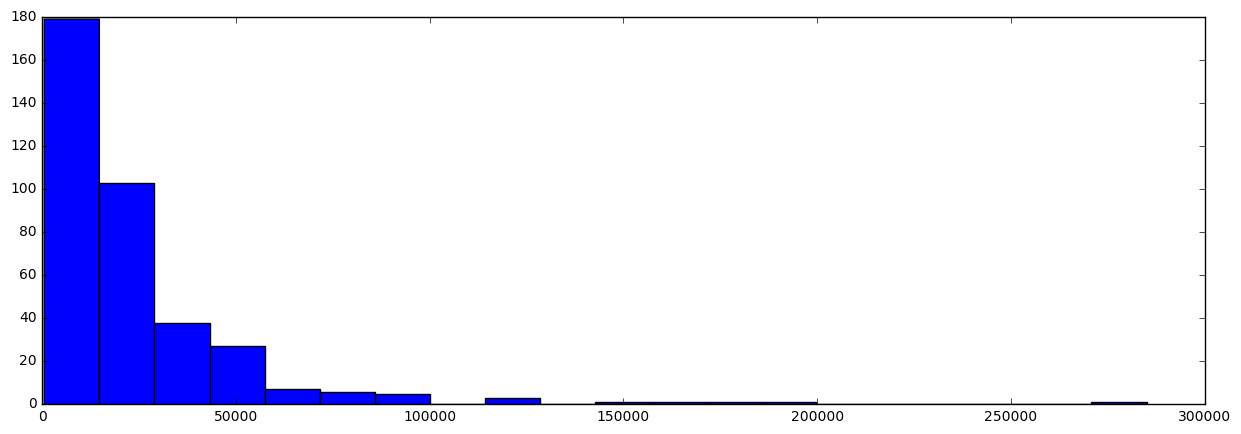

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

avg_ridership_counts = [ridership for ridership, station in traffic_report]
plt.figure(figsize=(15, 5))
hist = plt.hist(avg_ridership_counts, bins=20)

We can see that most stations have a small traffic and the histogram bins for large traffic volumes have small bars.

Let's plot a histogram with logarithmic scale instead.

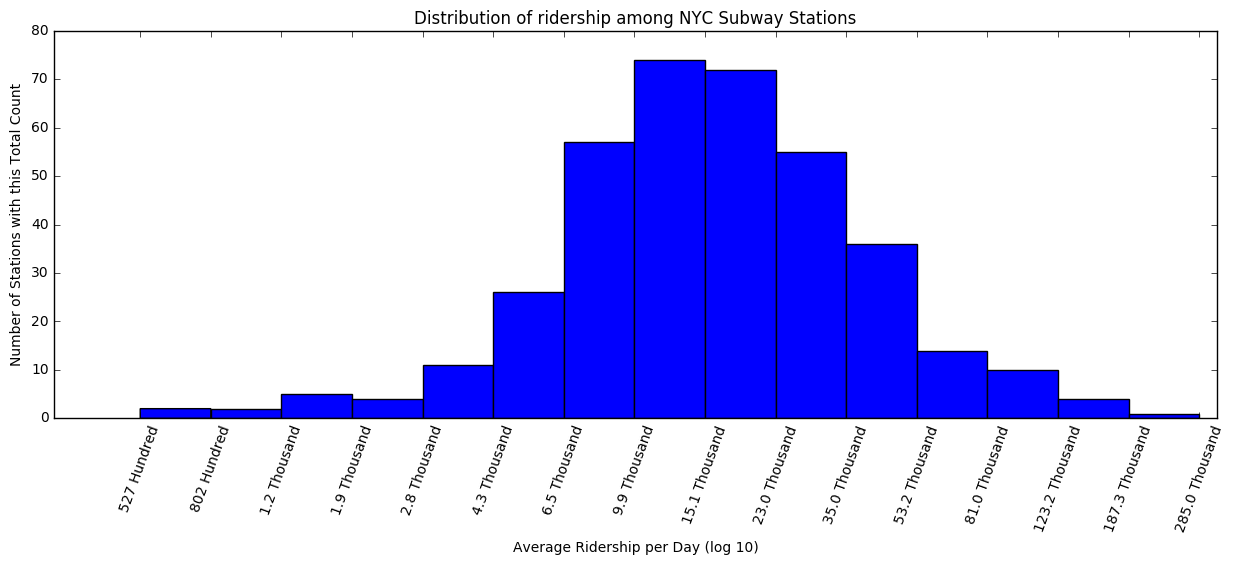

In [21]:
import math

log_counts = []

for count in avg_ridership_counts:
    try:
        log_result = math.log10(count)
    except:
        pass
    
    log_counts.append(log_result)
    
plt.figure(figsize=(15, 5))
n, bins, patches = hist = plt.hist(log_counts, bins=15)

def log_count_to_label(log_count):
    if log_count <= 3:
        return '{0:.0f} Hundred'.format(10 ** (log_count))
    else:
        return '{0:.1f} Thousand'.format(10 ** (log_count-3))

tick_labels = map(log_count_to_label, bins)
ticks = plt.xticks(bins, tick_labels, rotation=70)
plt.xlabel('Average Ridership per Day (log 10)')
plt.ylabel('Number of Stations with this Total Count')
plt.title('Distribution of ridership among NYC Subway Stations')

Since we are interested in filtering out at least 90% of stations let's select the top 30.

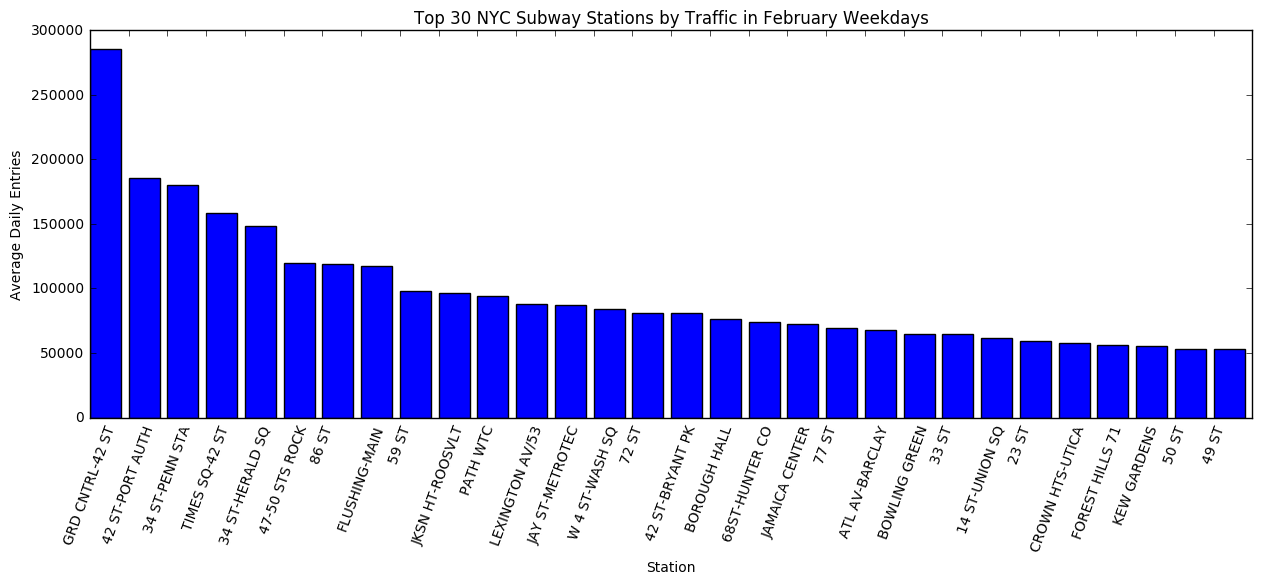

In [22]:
top_stations = traffic_report[:30]
avgs, stations = zip(*top_stations)
indices = range(len(avgs))
plt.figure(figsize=(15,5,))
plt.bar(indices, avgs)
ticks = plt.xticks(indices, stations, rotation = 70)
plt.xlabel('Station')
plt.ylabel('Average Daily Entries')
plt.title('Top 30 NYC Subway Stations by Traffic in February Weekdays')

plt.savefig('figures/mvp.png', bbox_inches='tight')

This could be our MVP. Let's save the traffic report as a binary `pickle` file and take a break to figure out how to improve the recommendations.

In [23]:
import pandas as pd

reversed_traffic_report = [reversed(t) for t in traffic_report]
df_to_pickle = pd.DataFrame(reversed_traffic_report, columns=['station', 'avg_daily_traffic_feb'])
df_to_pickle.head()

,station,avg_daily_traffic_feb
0,GRD CNTRL-42 ST,285004
1,42 ST-PORT AUTH,185601
2,34 ST-PENN STA,180414
3,TIMES SQ-42 ST,158313
4,34 ST-HERALD SQ,148468


In [24]:
df_to_pickle.to_pickle('pickle/stations_traffic.p')